In [3]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from network_revised import DotPerception, build_network

In [4]:
palette = sns.color_palette("colorblind")
palette2 = sns.color_palette("tab10")[2:4]
palette3 = sns.color_palette("viridis", 10)
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [3]:
def scan_nActions_coherence_spikes(
                   nActions=[2,4],
                   coherences=[0.0, 0.032, 0.064, 0.128, 0.256, 0.512],
                   trials=3,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   dt_sample=0.02,
                   ramp=1,
                   threshold=0.5,
                   relative=0,
                   tstart=0.3,
                   tend=0.3,
                   tmax=5.0,
                   name="scan_coherence_spikes"):
    

    dfs = []
    dfs2 = []
    for nAction in nActions:
        inputs = DotPerception(nActions=nAction, dt_sample=dt_sample, seed=perception_seed)
        for coherence in coherences:
            inputs.create(coherence=coherence, correct=0)
            for trial in range(trials):
                print(f"trial {trial}, coherence {coherence}, nActions {nAction}")
                net = build_network(inputs, nActions=nAction, seed=network_seed+trial, ramp=ramp, threshold=threshold, relative=relative, probe_spikes=True)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                RT = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > tmax:
                        break
                correct = 1 if choice==net.inputs.correct else 0
                aligned_neuron_idx = np.argwhere(sim.data[net.value].encoders[:,0] > 0.9)
                if RT > tstart:
                    for neuron in aligned_neuron_idx:
                        df = pd.DataFrame()
                        df['time'] = 1000*sim.trange()
                        df['nActions'] =  nAction*np.ones_like(sim.trange())
                        df['coherence'] =  100*coherence*np.ones_like(sim.trange())
                        df['trial'] =  trial*np.ones_like(sim.trange())
                        df['accuracy'] = 100*correct*np.ones_like(sim.trange())
                        df['RT'] = RT*np.ones_like(sim.trange())
                        df['neuron'] = neuron*np.ones_like(sim.trange())
                        df['firing rate'] = sim.data[net.pSpikes][:,neuron].ravel()
                        df['evidence'] = sim.data[net.pAccumulator][:,0].ravel()
                        df['value'] = sim.data[net.pValue][:,0].ravel()
                        dfs.append(df)
    
                        df2 = pd.DataFrame()
                        idx = int(tend/dt)
                        df2['time'] = np.arange(-tend/dt, 0)[-idx:]
                        df2['nActions'] =  nAction*np.ones_like(sim.trange())[-idx:]
                        df2['coherence'] =  100*coherence*np.ones_like(sim.trange())[-idx:]
                        df2['trial'] =  trial*np.ones_like(sim.trange())[-idx:]
                        df2['accuracy'] = 100*correct*np.ones_like(sim.trange())[-idx:]
                        df2['RT'] = RT*np.ones_like(sim.trange())[-idx:]
                        df2['neuron'] = neuron*np.ones_like(sim.trange())[-idx:]
                        df2['firing rate'] = sim.data[net.pSpikes][:,neuron].ravel()[-idx:]
                        df2['evidence'] = sim.data[net.pAccumulator][:,0].ravel()[-idx:]
                        df2['value'] = sim.data[net.pValue][:,0].ravel()[-idx:]
                        dfs2.append(df2)
                
    data = pd.concat(dfs, ignore_index=True)
    dat2 = pd.concat(dfs2, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")
    dat2.to_pickle(f"data/{name}2.pkl")

In [4]:
def plot_spikes(name, t0=150, t1=600):
    data_start = pd.read_pickle(f"data/{name}.pkl").query("time>@t0 & time<@t1")
    data_end = pd.read_pickle(f"data/{name}2.pkl")
    palette2 = sns.color_palette("viridis", len(data_start['coherence'].unique()))

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=((7.08, 4)))
    sns.lineplot(data=data_start.query("nActions==2"), x='time', y='firing rate', hue="coherence", palette=palette2, ax=axes[0][0])
    sns.lineplot(data=data_end.query("nActions==2"), x='time', y='firing rate', hue="coherence", palette=palette2, ax=axes[0][1])
    sns.lineplot(data=data_start.query("nActions==4"), x='time', y='firing rate', hue="coherence", palette=palette2, ax=axes[1][0])
    sns.lineplot(data=data_end.query("nActions==4"), x='time', y='firing rate', hue="coherence", palette=palette2, ax=axes[1][1])
    axes[0][0].set(xlabel=None, xticks=[], ylabel="Firing Rate (Hz)", title="Ramping Activities (2 Actions, Early)")
    axes[0][1].set(xlabel=None, xticks=[], ylabel=None, title="Ramping Activities (2 Actions, Late)")
    axes[1][0].set(xlabel="Time After Stimulus (ms)", ylabel=r"$\mathbf{\hat{x}}(t)$", title="Ramping Activities (4 Actions, Early)")
    axes[1][1].set(xlabel="Time Before Decision (ms)", ylabel=None, title="Ramping Activities (4 Actions, Late)")
    axes[0][1].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/{name}_activities.svg")
    fig.savefig(f"plots/{name}_activities.png", dpi=600)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=((7.08, 4)))
    sns.lineplot(data=data_start.query("nActions==2"), x='time', y='value', hue="coherence", palette=palette2, ax=axes[0][0])
    sns.lineplot(data=data_end.query("nActions==2"), x='time', y='value', hue="coherence", palette=palette2, ax=axes[0][1])
    sns.lineplot(data=data_start.query("nActions==4"), x='time', y='value', hue="coherence", palette=palette2, ax=axes[1][0])
    sns.lineplot(data=data_end.query("nActions==4"), x='time', y='value', hue="coherence", palette=palette2, ax=axes[1][1])
    axes[0][0].set(xlabel=None, xticks=[], ylabel="Firing Rate (Hz)", title="Ramping Decision Variables (2 Actions, Early)")
    axes[0][1].set(xlabel=None, xticks=[], ylabel=None, title="Ramping Decision Variables (2 Actions, Late)")
    axes[1][0].set(xlabel="Time After Stimulus (ms)", ylabel=r"$\mathbf{\hat{x}}(t)$", title="Ramping Decision Variables (4 Actions, Early)")
    axes[1][1].set(xlabel="Time Before Decision (ms)", ylabel=None, title="Ramping Decision Variables (4 Actions, Late)")
    axes[0][1].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/{name}_states.svg")
    fig.savefig(f"plots/{name}_states.png", dpi=600)

trial 0, coherence 0.1, nActions 2
trial 1, coherence 0.1, nActions 2
trial 2, coherence 0.1, nActions 2
trial 3, coherence 0.1, nActions 2
trial 4, coherence 0.1, nActions 2
trial 5, coherence 0.1, nActions 2
trial 6, coherence 0.1, nActions 2
trial 7, coherence 0.1, nActions 2
trial 8, coherence 0.1, nActions 2
trial 9, coherence 0.1, nActions 2
trial 10, coherence 0.1, nActions 2
trial 11, coherence 0.1, nActions 2
trial 12, coherence 0.1, nActions 2
trial 13, coherence 0.1, nActions 2
trial 14, coherence 0.1, nActions 2
trial 15, coherence 0.1, nActions 2
trial 16, coherence 0.1, nActions 2
trial 17, coherence 0.1, nActions 2
trial 18, coherence 0.1, nActions 2
trial 19, coherence 0.1, nActions 2
trial 20, coherence 0.1, nActions 2
trial 21, coherence 0.1, nActions 2
trial 22, coherence 0.1, nActions 2
trial 23, coherence 0.1, nActions 2
trial 24, coherence 0.1, nActions 2
trial 25, coherence 0.1, nActions 2
trial 26, coherence 0.1, nActions 2
trial 27, coherence 0.1, nActions 2
tr

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 14, coherence 0.3, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 15, coherence 0.3, nActions 2
trial 16, coherence 0.3, nActions 2
trial 17, coherence 0.3, nActions 2
trial 18, coherence 0.3, nActions 2
trial 19, coherence 0.3, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 20, coherence 0.3, nActions 2
trial 21, coherence 0.3, nActions 2
trial 22, coherence 0.3, nActions 2
trial 23, coherence 0.3, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 24, coherence 0.3, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 25, coherence 0.3, nActions 2
trial 26, coherence 0.3, nActions 2
trial 27, coherence 0.3, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 28, coherence 0.3, nActions 2
trial 29, coherence 0.3, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 0, coherence 0.5, nActions 2
trial 1, coherence 0.5, nActions 2
trial 2, coherence 0.5, nActions 2
trial 3, coherence 0.5, nActions 2
trial 4, coherence 0.5, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 5, coherence 0.5, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 6, coherence 0.5, nActions 2
trial 7, coherence 0.5, nActions 2
trial 8, coherence 0.5, nActions 2
trial 9, coherence 0.5, nActions 2
trial 10, coherence 0.5, nActions 2
trial 11, coherence 0.5, nActions 2
trial 12, coherence 0.5, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 13, coherence 0.5, nActions 2
trial 14, coherence 0.5, nActions 2
trial 15, coherence 0.5, nActions 2
trial 16, coherence 0.5, nActions 2
trial 17, coherence 0.5, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 18, coherence 0.5, nActions 2
trial 19, coherence 0.5, nActions 2
trial 20, coherence 0.5, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 21, coherence 0.5, nActions 2
trial 22, coherence 0.5, nActions 2
trial 23, coherence 0.5, nActions 2
trial 24, coherence 0.5, nActions 2
trial 25, coherence 0.5, nActions 2
trial 26, coherence 0.5, nActions 2
trial 27, coherence 0.5, nActions 2
trial 28, coherence 0.5, nActions 2
trial 29, coherence 0.5, nActions 2
trial 0, coherence 0.1, nActions 4
trial 1, coherence 0.1, nActions 4
trial 2, coherence 0.1, nActions 4
trial 3, coherence 0.1, nActions 4
trial 4, coherence 0.1, nActions 4
trial 5, coherence 0.1, nActions 4
trial 6, coherence 0.1, nActions 4
trial 7, coherence 0.1, nActions 4
trial 8, coherence 0.1, nActions 4
trial 9, coherence 0.1, nActions 4
trial 10, coherence 0.1, nActions 4
trial 11, coherence 0.1, nActions 4
trial 12, coherence 0.1, nActions 4
trial 13, coherence 0.1, nActions 4
trial 14, coherence 0.1, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 15, coherence 0.1, nActions 4
trial 16, coherence 0.1, nActions 4
trial 17, coherence 0.1, nActions 4
trial 18, coherence 0.1, nActions 4
trial 19, coherence 0.1, nActions 4
trial 20, coherence 0.1, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 21, coherence 0.1, nActions 4
trial 22, coherence 0.1, nActions 4
trial 23, coherence 0.1, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 24, coherence 0.1, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 25, coherence 0.1, nActions 4
trial 26, coherence 0.1, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 27, coherence 0.1, nActions 4
trial 28, coherence 0.1, nActions 4
trial 29, coherence 0.1, nActions 4
trial 0, coherence 0.3, nActions 4
trial 1, coherence 0.3, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 2, coherence 0.3, nActions 4
trial 3, coherence 0.3, nActions 4
trial 4, coherence 0.3, nActions 4
trial 5, coherence 0.3, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 6, coherence 0.3, nActions 4
trial 7, coherence 0.3, nActions 4
trial 8, coherence 0.3, nActions 4
trial 9, coherence 0.3, nActions 4
trial 10, coherence 0.3, nActions 4
trial 11, coherence 0.3, nActions 4
trial 12, coherence 0.3, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:516: CacheIOWarning: The cache index could not be updated because another program blocked access to it. This is commonly caused by anti-virus software. It is safe to ignore this warning. But if you see it a lot, you might want to consider doing one of the following for the best Nengo performance:
1. Configure your anti-virus to ignore the Nengo cache folder ('C:\Users\Peter Duggins\.nengo\cache\decoders').
2. Disable the cache.

  warnings.warn(


trial 13, coherence 0.3, nActions 4
trial 14, coherence 0.3, nActions 4
trial 15, coherence 0.3, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 16, coherence 0.3, nActions 4
trial 17, coherence 0.3, nActions 4
trial 18, coherence 0.3, nActions 4
trial 19, coherence 0.3, nActions 4
trial 20, coherence 0.3, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 21, coherence 0.3, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 22, coherence 0.3, nActions 4
trial 23, coherence 0.3, nActions 4
trial 24, coherence 0.3, nActions 4
trial 25, coherence 0.3, nActions 4
trial 26, coherence 0.3, nActions 4
trial 27, coherence 0.3, nActions 4
trial 28, coherence 0.3, nActions 4
trial 29, coherence 0.3, nActions 4
trial 0, coherence 0.5, nActions 4
trial 1, coherence 0.5, nActions 4
trial 2, coherence 0.5, nActions 4
trial 3, coherence 0.5, nActions 4
trial 4, coherence 0.5, nActions 4
trial 5, coherence 0.5, nActions 4
trial 6, coherence 0.5, nActions 4
trial 7, coherence 0.5, nActions 4
trial 8, coherence 0.5, nActions 4
trial 9, coherence 0.5, nActions 4
trial 10, coherence 0.5, nActions 4
trial 11, coherence 0.5, nActions 4
trial 12, coherence 0.5, nActions 4
trial 13, coherence 0.5, nActions 4
trial 14, coherence 0.5, nActions 4
trial 15, coherence 0.5, nActions 4
trial 16, coherence 0.5, nActions 4
trial 17, coherence 0.5, nActions 4
trial 18, coherence 0.5, nActions 4
trial 19, coherence 0.5, nActions 4
tr

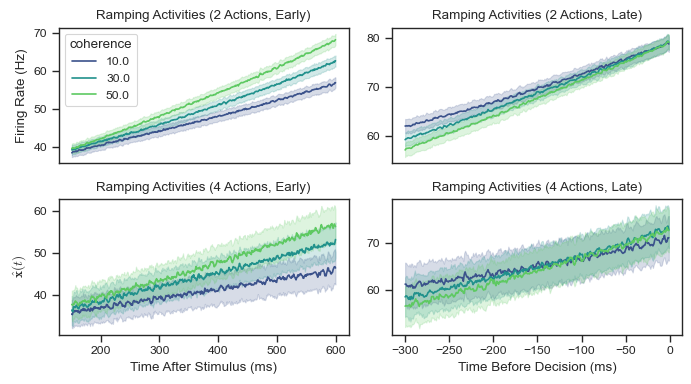

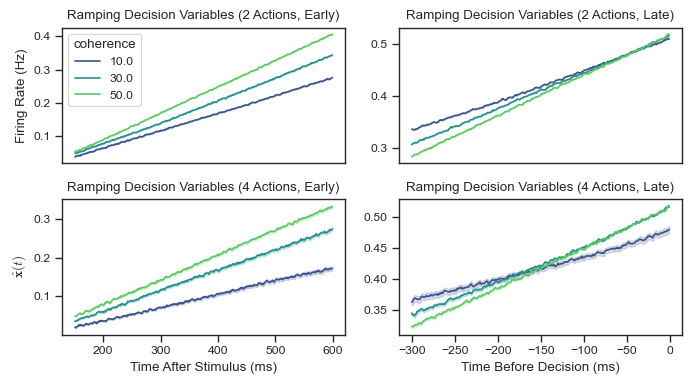

In [5]:
nActions = [2, 4]
coherences = [0.1, 0.3, 0.5]
dt_sample = 0.02
trials = 30
name = f"spaced_coherences"
scan_nActions_coherence_spikes(nActions=nActions, coherences=coherences, dt_sample=dt_sample, trials=trials, name=name)
plot_spikes(name)

trial 0, coherence 0.0, nActions 2
trial 1, coherence 0.0, nActions 2
trial 2, coherence 0.0, nActions 2
trial 3, coherence 0.0, nActions 2
trial 4, coherence 0.0, nActions 2
trial 5, coherence 0.0, nActions 2
trial 6, coherence 0.0, nActions 2
trial 7, coherence 0.0, nActions 2
trial 8, coherence 0.0, nActions 2
trial 9, coherence 0.0, nActions 2
trial 10, coherence 0.0, nActions 2
trial 11, coherence 0.0, nActions 2
trial 12, coherence 0.0, nActions 2
trial 13, coherence 0.0, nActions 2
trial 14, coherence 0.0, nActions 2
trial 15, coherence 0.0, nActions 2
trial 16, coherence 0.0, nActions 2
trial 17, coherence 0.0, nActions 2
trial 18, coherence 0.0, nActions 2
trial 19, coherence 0.0, nActions 2
trial 20, coherence 0.0, nActions 2
trial 21, coherence 0.0, nActions 2
trial 22, coherence 0.0, nActions 2
trial 23, coherence 0.0, nActions 2
trial 24, coherence 0.0, nActions 2
trial 25, coherence 0.0, nActions 2
trial 26, coherence 0.0, nActions 2
trial 27, coherence 0.0, nActions 2
tr

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 41, coherence 0.0, nActions 4
trial 42, coherence 0.0, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 43, coherence 0.0, nActions 4
trial 44, coherence 0.0, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 45, coherence 0.0, nActions 4
trial 46, coherence 0.0, nActions 4
trial 47, coherence 0.0, nActions 4
trial 48, coherence 0.0, nActions 4
trial 49, coherence 0.0, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 0, coherence 0.09, nActions 4
trial 1, coherence 0.09, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 2, coherence 0.09, nActions 4
trial 3, coherence 0.09, nActions 4
trial 4, coherence 0.09, nActions 4
trial 5, coherence 0.09, nActions 4
trial 6, coherence 0.09, nActions 4
trial 7, coherence 0.09, nActions 4
trial 8, coherence 0.09, nActions 4
trial 9, coherence 0.09, nActions 4
trial 10, coherence 0.09, nActions 4
trial 11, coherence 0.09, nActions 4
trial 12, coherence 0.09, nActions 4
trial 13, coherence 0.09, nActions 4
trial 14, coherence 0.09, nActions 4
trial 15, coherence 0.09, nActions 4
trial 16, coherence 0.09, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 17, coherence 0.09, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 18, coherence 0.09, nActions 4
trial 19, coherence 0.09, nActions 4
trial 20, coherence 0.09, nActions 4
trial 21, coherence 0.09, nActions 4
trial 22, coherence 0.09, nActions 4
trial 23, coherence 0.09, nActions 4
trial 24, coherence 0.09, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 25, coherence 0.09, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 26, coherence 0.09, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 27, coherence 0.09, nActions 4
trial 28, coherence 0.09, nActions 4
trial 29, coherence 0.09, nActions 4
trial 30, coherence 0.09, nActions 4
trial 31, coherence 0.09, nActions 4
trial 32, coherence 0.09, nActions 4
trial 33, coherence 0.09, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 34, coherence 0.09, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 35, coherence 0.09, nActions 4
trial 36, coherence 0.09, nActions 4
trial 37, coherence 0.09, nActions 4
trial 38, coherence 0.09, nActions 4
trial 39, coherence 0.09, nActions 4
trial 40, coherence 0.09, nActions 4
trial 41, coherence 0.09, nActions 4
trial 42, coherence 0.09, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 43, coherence 0.09, nActions 4
trial 44, coherence 0.09, nActions 4
trial 45, coherence 0.09, nActions 4
trial 46, coherence 0.09, nActions 4
trial 47, coherence 0.09, nActions 4
trial 48, coherence 0.09, nActions 4
trial 49, coherence 0.09, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 0, coherence 0.256, nActions 4
trial 1, coherence 0.256, nActions 4
trial 2, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 3, coherence 0.256, nActions 4
trial 4, coherence 0.256, nActions 4
trial 5, coherence 0.256, nActions 4
trial 6, coherence 0.256, nActions 4
trial 7, coherence 0.256, nActions 4
trial 8, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 9, coherence 0.256, nActions 4
trial 10, coherence 0.256, nActions 4
trial 11, coherence 0.256, nActions 4
trial 12, coherence 0.256, nActions 4
trial 13, coherence 0.256, nActions 4
trial 14, coherence 0.256, nActions 4
trial 15, coherence 0.256, nActions 4
trial 16, coherence 0.256, nActions 4
trial 17, coherence 0.256, nActions 4
trial 18, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 19, coherence 0.256, nActions 4
trial 20, coherence 0.256, nActions 4
trial 21, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 22, coherence 0.256, nActions 4
trial 23, coherence 0.256, nActions 4
trial 24, coherence 0.256, nActions 4
trial 25, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 26, coherence 0.256, nActions 4
trial 27, coherence 0.256, nActions 4
trial 28, coherence 0.256, nActions 4
trial 29, coherence 0.256, nActions 4
trial 30, coherence 0.256, nActions 4
trial 31, coherence 0.256, nActions 4
trial 32, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 33, coherence 0.256, nActions 4
trial 34, coherence 0.256, nActions 4
trial 35, coherence 0.256, nActions 4
trial 36, coherence 0.256, nActions 4
trial 37, coherence 0.256, nActions 4
trial 38, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 39, coherence 0.256, nActions 4
trial 40, coherence 0.256, nActions 4
trial 41, coherence 0.256, nActions 4
trial 42, coherence 0.256, nActions 4
trial 43, coherence 0.256, nActions 4
trial 44, coherence 0.256, nActions 4
trial 45, coherence 0.256, nActions 4
trial 46, coherence 0.256, nActions 4
trial 47, coherence 0.256, nActions 4
trial 48, coherence 0.256, nActions 4
trial 49, coherence 0.256, nActions 4


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


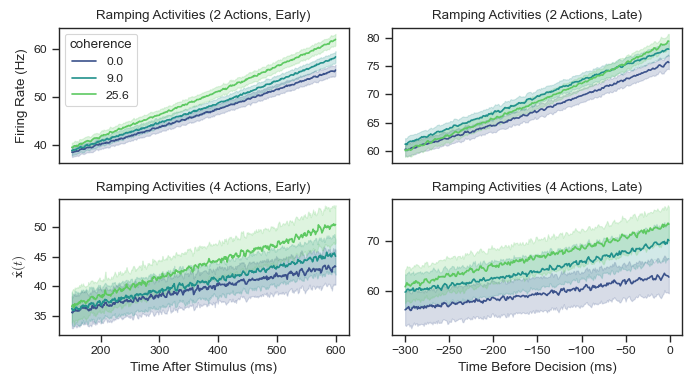

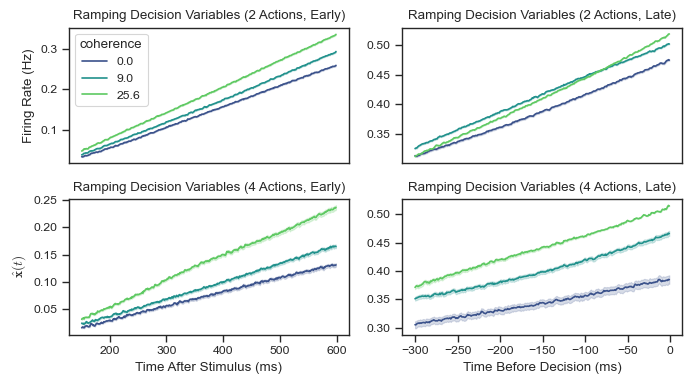

In [6]:
nActions = [2, 4]
coherences = [0.0, 0.09, 0.256]
dt_sample = 0.02
trials = 50
name = f"churchland_coherences"
scan_nActions_coherence_spikes(nActions=nActions, coherences=coherences, dt_sample=dt_sample, trials=trials, name=name)
plot_spikes(name)

In [64]:
def scan_nActions_coherence_buildup(
                   conditions=['speed', 'accuracy'],
                   nActions=[2,4],
                   coherences=[0.0, 0.032, 0.064, 0.128, 0.256, 0.512],
                   trials=3,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   dt_sample=0.02,
                   relative=0,
                   tmin=0.3,
                   tmax=5.0,
                   tstart=0.15,
                   name="buildup"):

    dfs = []
    for condition in conditions:
        if condition=="speed":
            ramp, threshold = 1.5, 0.5
        if condition=="accuracy":
            ramp, threshold = 1.0, 0.5
        for nAction in nActions:
            inputs = DotPerception(nActions=nAction, dt_sample=dt_sample, seed=perception_seed)
            for coherence in coherences:
                inputs.create(coherence=coherence, correct=0)
                for trial in range(trials):
                    print(f"trial {trial}, coherence {coherence}, nActions {nAction}, condition {condition}")
                    net = build_network(inputs, nActions=nAction, seed=network_seed+trial, ramp=ramp, threshold=threshold, relative=relative, probe_spikes=True)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    RT = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > tmax:
                            break
                    correct = 1 if choice==net.inputs.correct else 0
                    aligned_neuron_idx = np.argwhere(sim.data[net.value].encoders[:,0] > 0.9)
                    aligned_rates = sim.data[net.pSpikes][:,aligned_neuron_idx]
                    if RT > tstart:
                        buildup_rates = (aligned_rates[-1] - aligned_rates[int(tstart/dt)]) / (RT - tstart)
                        buildup_rates = buildup_rates.ravel()
                        df = pd.DataFrame()
                        df['condition'] =  [condition for _ in buildup_rates]
                        df['nActions'] =  nAction*np.ones_like(buildup_rates)
                        df['coherence'] =  100*coherence*np.ones_like(buildup_rates)
                        df['trial'] =  trial*np.ones_like(buildup_rates)
                        df['accuracy'] =  100*correct*np.ones_like(buildup_rates)
                        df['RT'] =  RT*np.ones_like(buildup_rates)
                        df['rate buildup'] = buildup_rates
                        dfs.append(df)
                
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

In [65]:
def plot_buildup(name):
    print(name)
    data = pd.read_pickle(f"data/{name}.pkl")
    print(data)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((7.08, 3)))
    sns.lineplot(data=data, x='coherence', y='rate buildup', hue="condition", style="nActions", palette=palette[:2], ax=ax)
    plt.tight_layout()

trial 0, coherence 0.0, nActions 2, condition speed
trial 1, coherence 0.0, nActions 2, condition speed
trial 2, coherence 0.0, nActions 2, condition speed
trial 3, coherence 0.0, nActions 2, condition speed
trial 4, coherence 0.0, nActions 2, condition speed
trial 5, coherence 0.0, nActions 2, condition speed
trial 6, coherence 0.0, nActions 2, condition speed
trial 7, coherence 0.0, nActions 2, condition speed
trial 8, coherence 0.0, nActions 2, condition speed
trial 9, coherence 0.0, nActions 2, condition speed
trial 10, coherence 0.0, nActions 2, condition speed
trial 11, coherence 0.0, nActions 2, condition speed
trial 12, coherence 0.0, nActions 2, condition speed
trial 13, coherence 0.0, nActions 2, condition speed
trial 14, coherence 0.0, nActions 2, condition speed
trial 15, coherence 0.0, nActions 2, condition speed
trial 16, coherence 0.0, nActions 2, condition speed
trial 17, coherence 0.0, nActions 2, condition speed
trial 18, coherence 0.0, nActions 2, condition speed
tri

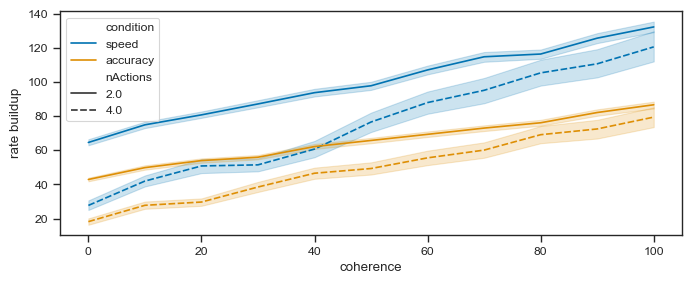

In [66]:
conditions = ["speed", "accuracy"]
nActions = [2, 4]
coherences = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dt_sample = 0.02
trials = 30
name = f"rate_buildup"
scan_nActions_coherence_buildup(conditions=conditions, nActions=nActions, coherences=coherences, dt_sample=dt_sample, trials=trials, name=name)
plot_buildup(name)